In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#with diffusion
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Conv3D,
    Conv3DTranspose,
    MaxPooling3D,
    UpSampling3D,
    concatenate,
    ReLU, Dropout,BatchNormalization
)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.compat.v1.logging import INFO, set_verbosity

set_verbosity(INFO)

import tensorflow.python.keras.backend as K
K.set_image_data_format("channels_first")

In [ ]:
def create_convolution_block(input_layer, n_filters, batch_normalization=False, kernel=(3, 3, 3), activation=None, padding='same', strides=(1, 1, 1), instance_normalization=False):

    layer = Conv3D(n_filters, kernel, padding=padding, strides=strides)(input_layer)
    act_layer=Activation('relu')(layer)
    bn_layer=BatchNormalization()(act_layer)
#     dr_layer=Dropout(0.4)(bn_layer)
    # if activation is None:
    #     return Activation('relu')(layer)
    # else:
    #     return activation()(layer)
    return bn_layer

# Defining upconvolution
def get_up_convolution(n_filters, pool_size, kernel_size=(2, 2, 2), strides=(2, 2, 2), deconvolution=False):
    if deconvolution:
        return Conv3DTranspose(filters=n_filters, kernel_size=kernel_size, strides=strides)
    else:
        return UpSampling3D(size=pool_size)

# Defining the 3D unet model
def unet_model_3d(loss_function, input_shape=(32, 64, 64, 3), pool_size=(2, 2, 2), n_labels=3, initial_learning_rate=0.0001, deconvolution=False, depth=6, n_base_filters=32,
                  include_label_wise_dice_coefficients=False, metrics=[], batch_normalization=False, activation_name="sigmoid"):

    inputs = Input(input_shape)
    current_layer = inputs
    levels = list()

    # add levels with max pooling
    for layer_depth in range(depth):
        layer1 = create_convolution_block(input_layer=current_layer, n_filters=n_base_filters * (2 ** layer_depth), batch_normalization=batch_normalization)
        #layer1=Dropout(0.5)(layer1)

        layer2 = create_convolution_block(input_layer=layer1, n_filters=n_base_filters * (2 ** layer_depth) * 2, batch_normalization=batch_normalization)
        #layer2=Dropout(0.5)(layer2)

        if layer_depth < depth - 1:
            current_layer = MaxPooling3D(pool_size=pool_size)(layer2)
            levels.append([layer1, layer2, current_layer])
        else:
            current_layer = layer2
            levels.append([layer1, layer2])

    for layer_depth in range(depth - 2, -1, -1):
        up_convolution = get_up_convolution(pool_size=pool_size, deconvolution=deconvolution, n_filters=current_layer.shape[1])(current_layer)
        concat = concatenate([up_convolution, levels[layer_depth][1]], axis=4)
        current_layer = create_convolution_block(n_filters=levels[layer_depth][1].shape[4], input_layer=concat, batch_normalization=batch_normalization)
        #current_layer=Dropout(0.5)(current_layer)
        current_layer = create_convolution_block(n_filters=levels[layer_depth][1].shape[4], input_layer=current_layer, batch_normalization=batch_normalization)
        #current_layer=Dropout(0.5)(current_layer)

    final_convolution = Conv3D(n_labels, (1, 1, 1))(current_layer)
    act = Activation(activation_name)(final_convolution)
    act=Dropout(0.5)(act)
    model = Model(inputs=inputs, outputs=act)

    if not isinstance(metrics, list):
        metrics = [metrics]

    model.compile(optimizer=Adam(lr=initial_learning_rate), loss=loss_function,
                  metrics=metrics)
    return model

# ins=(32, 64, 64,3)
# #model=unet_3d_model(ins,lfunc=dice_coefficient_loss,metrics=[dice_coefficient])
# model=unet_model_3d(dice_coefficient_loss,metrics=[dice_coefficient])
# model.summary()

In [ ]:
# Loss Function and coefficients to be used during training:
def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [ ]:
ins=(32, 64, 64,3)
#model=unet_3d_model(ins,lfunc=dice_coefficient_loss,metrics=[dice_coefficient])
model=unet_model_3d(dice_coefficient_loss,metrics=[dice_coefficient])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 64,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 32, 64, 64, 3 2624        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 64, 64, 3 0           conv3d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 64, 3 128         activation[0][0]                 
______________________________________________________________________________________________

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
!pip install patchify

In [ ]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [ ]:
HOME_DIR = "../input/pddca-dataset/pddca/"
DATA_DIR = HOME_DIR

def load_case(imgfile, labelfile):
    # load the image and label file, get the image content and return a numpy array for each
    image = np.array(np.load(imgfile))
    label = np.array(np.load(labelfile))

    return image, label

In [ ]:
img=[]
msk=[]
for dir in os.listdir(DATA_DIR):
    imfile=DATA_DIR+str(dir)+"/img_crp_v2.npy"
    lbfile=DATA_DIR+str(dir)+"/structures/mask.npy"
    if(os.path.isfile(lbfile)):
        im,ms=load_case(imfile,lbfile)
        img.append(im)
        msk.append(ms)

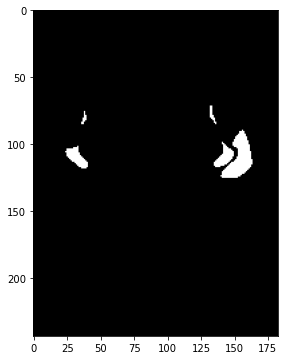

In [ ]:
plt.figure(figsize=(14,6))
im1=msk[0]
plt.imshow(im1[36,:,:],cmap='gray')

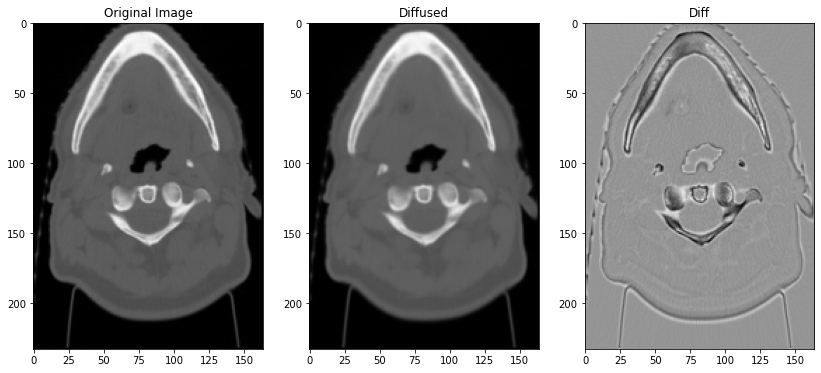

In [ ]:
#anisotropic diffusion
import warnings
from PIL import Image
import matplotlib
import skimage.io as io
import skimage.filters as flt
%matplotlib inline
import scipy.ndimage.filters as flt


def anisodiff3(stack,niter=1,kappa=50,gamma=0.1,step=(1.,1.,1.),option=1,ploton=False):

    # ...you could always diffuse each color channel independently if you
    # really want
    if stack.ndim == 4:
        warnings.warn("Only grayscale stacks allowed, converting to 3D matrix")
        stack = stack.mean(3)

    # initialize output array
    stack = stack.astype('float32')
    stackout = stack.copy()

    # initialize some internal variables
    deltaS = np.zeros_like(stackout)
    deltaE = deltaS.copy()
    deltaD = deltaS.copy()
    NS = deltaS.copy()
    EW = deltaS.copy()
    UD = deltaS.copy()
    gS = np.ones_like(stackout)
    gE = gS.copy()
    gD = gS.copy()

    # create the plot figure, if requested
    if ploton:
        import pylab as pl
        from time import sleep

        showplane = stack.shape[0]//2

        fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
        ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

        ax1.imshow(stack[showplane,...].squeeze(),interpolation='nearest')
        ih = ax2.imshow(stackout[showplane,...].squeeze(),interpolation='nearest',animated=True)
        ax1.set_title("Original stack (Z = %i)" %showplane)
        ax2.set_title("Iteration 0")

        fig.canvas.draw()

    for ii in range(niter):

        # calculate the diffs
        deltaD[:-1,: ,:  ] = np.diff(stackout,axis=0)
        deltaS[:  ,:-1,: ] = np.diff(stackout,axis=1)
        deltaE[:  ,: ,:-1] = np.diff(stackout,axis=2)

        # conduction gradients (only need to compute one per dim!)
        if option == 1:
            gD = np.exp(-(deltaD/kappa)**2.)/step[0]
            gS = np.exp(-(deltaS/kappa)**2.)/step[1]
            gE = np.exp(-(deltaE/kappa)**2.)/step[2]
        elif option == 2:
            gD = 1./(1.+(deltaD/kappa)**2.)/step[0]
            gS = 1./(1.+(deltaS/kappa)**2.)/step[1]
            gE = 1./(1.+(deltaE/kappa)**2.)/step[2]

        # update matrices
        D = gD*deltaD
        E = gE*deltaE
        S = gS*deltaS

        # subtract a copy that has been shifted 'Up/North/West' by one pixel
        UD[:] = D
        NS[:] = S
        EW[:] = E
        UD[1:,: ,: ] -= D[:-1,:  ,:  ]
        NS[: ,1:,: ] -= S[:  ,:-1,:  ]
        EW[: ,: ,1:] -= E[:  ,:  ,:-1]

        # update the image
        stackout += gamma*(UD+NS+EW)

        if ploton:
            iterstring = "Iteration %i" %(ii+1)
            ih.set_data(stackout[showplane,...].squeeze())
            ax2.set_title(iterstring)
            fig.canvas.draw()
            # sleep(0.01)

    return stackout

#diffusion on image
im3= img[3]
fimg=anisodiff3(im3)

# print(im3.shape)
# print(fimg.shape)
plt.figure(figsize=(14,6))
plt.subplot(131)
plt.title('Original Image')
plt.imshow(im3[22],cmap='gray')

plt.subplot(132)
plt.title('Diffused')
plt.imshow(fimg[22],cmap='gray')

dimg=fimg-im3
plt.subplot(133)
plt.title('Diff')
plt.imshow(dimg[22],cmap='gray')

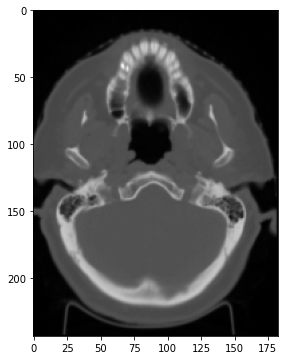

In [ ]:
dimg=[]
dmsk=msk
for i in range(len(img)):
    aimg=anisodiff3(img[i])
    dimg.append(aimg)
    # amsk=anisodiff3(msk[i])
    # dmsk.append(amsk)

plt.figure(figsize=(14,6))
im1=dimg[0]
plt.imshow(im1[36,:,:],cmap='gray')
# for i in range(len(dimg)):
#   print(dimg[i].shape)

In [ ]:
from patchify import patchify
import tensorflow as tf


img_patches = patchify(dimg[0], (32, 64, 64), step=64)
mask_patches  = patchify(msk[0], (32, 64, 64), step=64)
input_img = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))

train_img = np.stack((input_img,)*3, axis=-1)
train_mask = np.stack((input_mask,)*3, axis=-1)
# train_mask = to_categorical(input_mask, num_classes=3)

#train_img=np.expand_dims(train_img,axis=4)
#train_mask = np.expand_dims(input_mask, axis=4)


train_img=tf.cast(train_img, tf.float32)
train_mask=tf.cast(train_mask, tf.float32)



img_patches1 = patchify(dimg[1], (32, 64, 64), step=64)
mask_patches1  = patchify(msk[1], (32, 64, 64), step=64)
input_img1 = np.reshape(img_patches1, (-1, img_patches1.shape[3], img_patches1.shape[4], img_patches1.shape[5]))
input_mask1 = np.reshape(mask_patches1, (-1, mask_patches1.shape[3], mask_patches1.shape[4], mask_patches1.shape[5]))

train_img1 = np.stack((input_img1,)*3, axis=-1)
train_mask1 = np.stack((input_mask1,)*3, axis=-1)
#train_mask1 = to_categorical(input_mask1, num_classes=3)
#train_img=np.expand_dims(train_img,axis=4)
#train_mask = np.expand_dims(input_mask, axis=4)

train_img1=tf.cast(train_img1, tf.float32)
train_mask1=tf.cast(train_mask1, tf.float32)
#tf.cast(train_mask_cat1, tf.float32)


tri=np.concatenate((train_img,train_img1),axis=0)
trm=np.concatenate((train_mask,train_mask1),axis=0)
print(tri.shape)
print(trm.shape)

(15, 32, 64, 64, 3)
(15, 32, 64, 64, 3)


In [ ]:
for i in range(2,len(img)):
    img_patches = patchify(dimg[i], (32, 64, 64), step=64)
    mask_patches  = patchify(msk[i], (32, 64, 64), step=64)
    input_img = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
    input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))

    train_img = np.stack((input_img,)*3, axis=-1)
    train_mask = np.stack((input_mask,)*3, axis=-1)
      #train_mask = to_categorical(input_mask, num_classes=3)
      #train_img=np.expand_dims(train_img,axis=4)
      #train_mask = np.expand_dims(input_mask, axis=4)



      #train_mask_cat = to_categorical(input_mask, num_classes=3)
    train_img=tf.cast(train_img, tf.float32)
    train_mask=tf.cast(train_mask, tf.float32)

    tri=np.concatenate((tri,train_img),axis=0)
    trm=np.concatenate((trm,train_mask),axis=0)


print(tri.shape)
print(trm.shape)

(346, 32, 64, 64, 3)
(346, 32, 64, 64, 3)


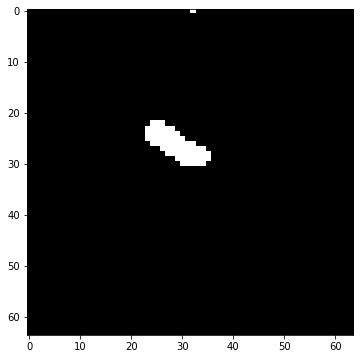

In [ ]:
plt.figure(figsize=(14,6))
im1=trm[35]
plt.imshow(im1[31,:,:])

In [ ]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(tri, trm, test_size = 0.10,random_state=36)
X_train, X_test, y_train, y_test = train_test_split(X_tr, y_tr, test_size = 0.10, random_state=36)

In [ ]:
# lrs=[0.001, 0.0001, 0.00001, 0.000001]
# lf=[]
# vlf=[]
# for lr in lrs:
#     model=unet_model_3d(dice_coefficient_loss,initial_learning_rate=lr, metrics=[dice_coefficient])
#     bs=24
#     for i in range(0,len(X_train),bs):
#         X_batch=X_train[i:i+bs]
#         y_batch=y_train[i:i+bs]
#         history=model.fit(X_batch,y_batch,epochs=20,batch_size=8,validation_split=0.1)
#       #history=model.fit(X_train,y_train,epochs=10,batch_size=8)
#     lf.append(history.history['loss'][-1])
#     vlf.append(history.history['val_loss'][-1])


# plt.plot(lrs, lf)
# plt.xscale('log')
# plt.xlabel('Learning rate (log scale)')
# plt.ylabel('Loss')
# plt.show()

In [ ]:
# plt.plot(lrs, lf,label='train')
# plt.plot(lrs,vlf,label='val')
# plt.xscale('log')
# plt.xlabel('Learning rate (log scale)')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
# model=unet_model_3d(dice_coefficient_loss,initial_learning_rate=0.0001, metrics=[dice_coefficient])
# history=model.train_on_batch(X_train,y_train)

In [ ]:
from keras.callbacks import EarlyStopping

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
3/3 [==============================] - 43s 5s/step - loss: 0.9265 - dice_coefficient: 0.0735 - val_loss: 0.9487 - val_dice_coefficient: 0.0482
Epoch 2/200
3/3 [==============================] - 10s 4s/step - loss: 0.8992 - dice_coefficient: 0.1008 - val_loss: 0.9479 - val_dice_coefficient: 0.0490
Epoch 3/200
3/3 [==============================] - 12s 5s/step - loss: 0.8835 - dice_coefficient: 0.1165 - val_loss: 0.9482 - val_dice_coefficient: 0.0487
Epoch 4/200
3/3 [==============================] - 12s 5s/step - loss: 0.8731 - dice_coefficient: 0.1269 - val_loss: 0.9483 - val_dice_coefficient: 0.0485
Epoch 5/200
3/3 [==============================] - 10s 4s/step - loss: 0.8693 - dice_coefficient: 0.1307 - val_loss: 0.9483 - val_dice_coefficient: 0.0484
Epoch 6/200
3/3 [==============================] - 12s 5s/step - loss: 0.8606 - dice_coefficient: 0.1394 - val_loss: 0.9492 - val_dice_coefficient: 0.0476
Epoch 7/200
3/3 [==============================] - 10s 4s/step - loss:

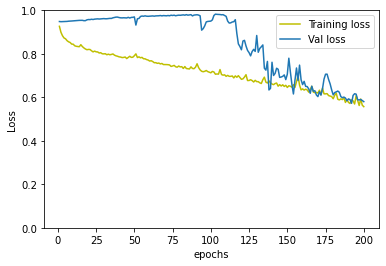

Epoch 1/200
3/3 [==============================] - 11s 4s/step - loss: 0.6057 - dice_coefficient: 0.3943 - val_loss: 0.5422 - val_dice_coefficient: 0.4478
Epoch 2/200
3/3 [==============================] - 12s 5s/step - loss: 0.5735 - dice_coefficient: 0.4265 - val_loss: 0.5528 - val_dice_coefficient: 0.4468
Epoch 3/200
3/3 [==============================] - 11s 4s/step - loss: 0.5714 - dice_coefficient: 0.4286 - val_loss: 0.5393 - val_dice_coefficient: 0.4637
Epoch 4/200
3/3 [==============================] - 13s 5s/step - loss: 0.5821 - dice_coefficient: 0.4179 - val_loss: 0.5583 - val_dice_coefficient: 0.4461
Epoch 5/200
3/3 [==============================] - 10s 4s/step - loss: 0.5759 - dice_coefficient: 0.4241 - val_loss: 0.6576 - val_dice_coefficient: 0.3368
Epoch 6/200
3/3 [==============================] - 12s 5s/step - loss: 0.5988 - dice_coefficient: 0.4012 - val_loss: 0.8530 - val_dice_coefficient: 0.1386
Epoch 7/200
3/3 [==============================] - 12s 5s/step - loss:

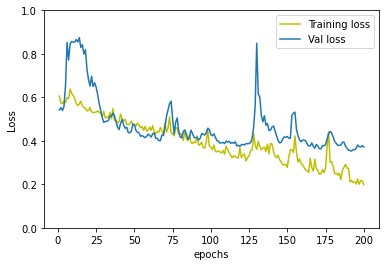

Epoch 1/200
3/3 [==============================] - 11s 4s/step - loss: 0.5743 - dice_coefficient: 0.4257 - val_loss: 0.3573 - val_dice_coefficient: 0.6543
Epoch 2/200
3/3 [==============================] - 12s 5s/step - loss: 0.4573 - dice_coefficient: 0.5427 - val_loss: 0.4607 - val_dice_coefficient: 0.5341
Epoch 3/200
3/3 [==============================] - 10s 4s/step - loss: 0.4014 - dice_coefficient: 0.5986 - val_loss: 0.4850 - val_dice_coefficient: 0.5051
Epoch 4/200
3/3 [==============================] - 12s 5s/step - loss: 0.4073 - dice_coefficient: 0.5927 - val_loss: 0.4559 - val_dice_coefficient: 0.5326
Epoch 5/200
3/3 [==============================] - 12s 5s/step - loss: 0.3556 - dice_coefficient: 0.6444 - val_loss: 0.3633 - val_dice_coefficient: 0.6469
Epoch 6/200
3/3 [==============================] - 10s 4s/step - loss: 0.4151 - dice_coefficient: 0.5849 - val_loss: 0.3578 - val_dice_coefficient: 0.6493
Epoch 7/200
3/3 [==============================] - 10s 4s/step - loss:

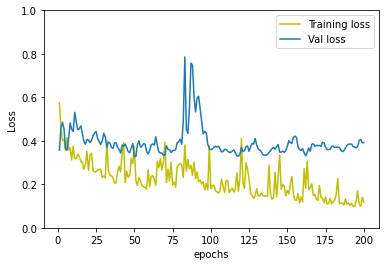

Epoch 1/200
3/3 [==============================] - 13s 5s/step - loss: 0.4396 - dice_coefficient: 0.5604 - val_loss: 0.3332 - val_dice_coefficient: 0.6857
Epoch 2/200
3/3 [==============================] - 12s 5s/step - loss: 0.3400 - dice_coefficient: 0.6600 - val_loss: 0.3114 - val_dice_coefficient: 0.7029
Epoch 3/200
3/3 [==============================] - 13s 5s/step - loss: 0.2966 - dice_coefficient: 0.7034 - val_loss: 0.4316 - val_dice_coefficient: 0.5745
Epoch 4/200
3/3 [==============================] - 11s 4s/step - loss: 0.3094 - dice_coefficient: 0.6906 - val_loss: 0.3844 - val_dice_coefficient: 0.6234
Epoch 5/200
3/3 [==============================] - 10s 4s/step - loss: 0.2744 - dice_coefficient: 0.7256 - val_loss: 0.3809 - val_dice_coefficient: 0.6249
Epoch 6/200
3/3 [==============================] - 12s 5s/step - loss: 0.2526 - dice_coefficient: 0.7474 - val_loss: 0.3746 - val_dice_coefficient: 0.6314
Epoch 7/200
3/3 [==============================] - 12s 5s/step - loss:

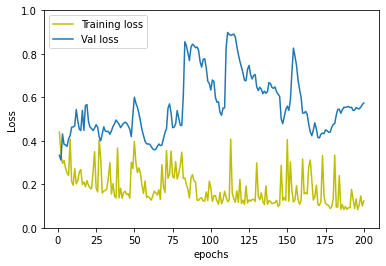

Epoch 1/200
3/3 [==============================] - 13s 5s/step - loss: 0.4971 - dice_coefficient: 0.5029 - val_loss: 0.4433 - val_dice_coefficient: 0.5749
Epoch 2/200
3/3 [==============================] - 11s 4s/step - loss: 0.4448 - dice_coefficient: 0.5552 - val_loss: 0.3764 - val_dice_coefficient: 0.6474
Epoch 3/200
3/3 [==============================] - 13s 5s/step - loss: 0.3738 - dice_coefficient: 0.6262 - val_loss: 0.3640 - val_dice_coefficient: 0.6555
Epoch 4/200
3/3 [==============================] - 11s 4s/step - loss: 0.3491 - dice_coefficient: 0.6509 - val_loss: 0.4058 - val_dice_coefficient: 0.6015
Epoch 5/200
3/3 [==============================] - 10s 4s/step - loss: 0.3005 - dice_coefficient: 0.6995 - val_loss: 0.4782 - val_dice_coefficient: 0.5290
Epoch 6/200
3/3 [==============================] - 12s 5s/step - loss: 0.3030 - dice_coefficient: 0.6970 - val_loss: 0.5088 - val_dice_coefficient: 0.5068
Epoch 7/200
3/3 [==============================] - 10s 4s/step - loss:

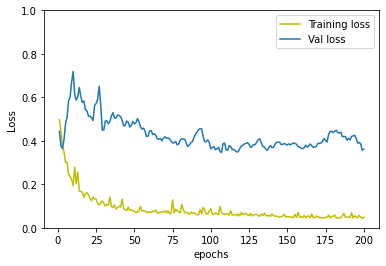

Epoch 1/200
3/3 [==============================] - 11s 4s/step - loss: 0.4230 - dice_coefficient: 0.5770 - val_loss: 0.2857 - val_dice_coefficient: 0.7314
Epoch 2/200
3/3 [==============================] - 12s 5s/step - loss: 0.3292 - dice_coefficient: 0.6708 - val_loss: 0.3179 - val_dice_coefficient: 0.6897
Epoch 3/200
3/3 [==============================] - 12s 5s/step - loss: 0.4981 - dice_coefficient: 0.5019 - val_loss: 0.3437 - val_dice_coefficient: 0.6542
Epoch 4/200
3/3 [==============================] - 12s 5s/step - loss: 0.3946 - dice_coefficient: 0.6054 - val_loss: 0.3608 - val_dice_coefficient: 0.6439
Epoch 5/200
3/3 [==============================] - 12s 5s/step - loss: 0.2131 - dice_coefficient: 0.7869 - val_loss: 0.3935 - val_dice_coefficient: 0.6155
Epoch 6/200
3/3 [==============================] - 10s 4s/step - loss: 0.2418 - dice_coefficient: 0.7582 - val_loss: 0.3531 - val_dice_coefficient: 0.6626
Epoch 7/200
3/3 [==============================] - 10s 4s/step - loss:

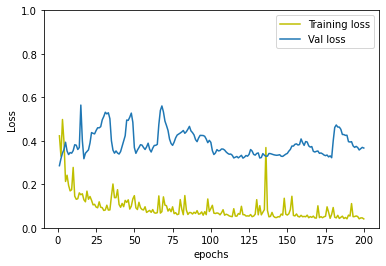

Epoch 1/200
3/3 [==============================] - 13s 5s/step - loss: 0.3322 - dice_coefficient: 0.6678 - val_loss: 0.3115 - val_dice_coefficient: 0.7040
Epoch 2/200
3/3 [==============================] - 12s 5s/step - loss: 0.2848 - dice_coefficient: 0.7152 - val_loss: 0.3219 - val_dice_coefficient: 0.6912
Epoch 3/200
3/3 [==============================] - 10s 4s/step - loss: 0.2953 - dice_coefficient: 0.7047 - val_loss: 0.3783 - val_dice_coefficient: 0.6393
Epoch 4/200
3/3 [==============================] - 12s 5s/step - loss: 0.2297 - dice_coefficient: 0.7703 - val_loss: 0.3973 - val_dice_coefficient: 0.6143
Epoch 5/200
3/3 [==============================] - 12s 5s/step - loss: 0.1719 - dice_coefficient: 0.8281 - val_loss: 0.3937 - val_dice_coefficient: 0.6175
Epoch 6/200
3/3 [==============================] - 12s 5s/step - loss: 0.1758 - dice_coefficient: 0.8242 - val_loss: 0.3837 - val_dice_coefficient: 0.6341
Epoch 7/200
3/3 [==============================] - 10s 4s/step - loss:

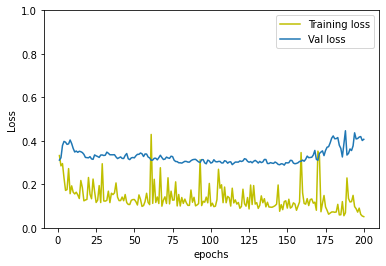

Epoch 1/200
3/3 [==============================] - 11s 4s/step - loss: 0.4467 - dice_coefficient: 0.5533 - val_loss: 0.3865 - val_dice_coefficient: 0.6408
Epoch 2/200
3/3 [==============================] - 10s 4s/step - loss: 0.3499 - dice_coefficient: 0.6501 - val_loss: 0.3863 - val_dice_coefficient: 0.6350
Epoch 3/200
3/3 [==============================] - 11s 4s/step - loss: 0.2772 - dice_coefficient: 0.7228 - val_loss: 0.3986 - val_dice_coefficient: 0.6184
Epoch 4/200
3/3 [==============================] - 11s 4s/step - loss: 0.2293 - dice_coefficient: 0.7707 - val_loss: 0.4775 - val_dice_coefficient: 0.5475
Epoch 5/200
3/3 [==============================] - 12s 5s/step - loss: 0.2360 - dice_coefficient: 0.7640 - val_loss: 0.5107 - val_dice_coefficient: 0.5165
Epoch 6/200
3/3 [==============================] - 12s 5s/step - loss: 0.1860 - dice_coefficient: 0.8140 - val_loss: 0.5050 - val_dice_coefficient: 0.5070
Epoch 7/200
3/3 [==============================] - 10s 4s/step - loss:

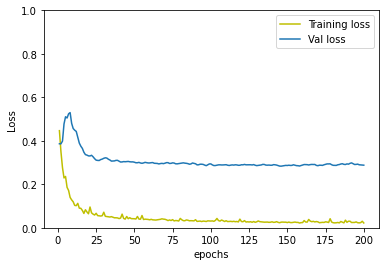

Epoch 1/200
3/3 [==============================] - 11s 4s/step - loss: 0.3056 - dice_coefficient: 0.6944 - val_loss: 0.2816 - val_dice_coefficient: 0.7348
Epoch 2/200
3/3 [==============================] - 10s 4s/step - loss: 0.2321 - dice_coefficient: 0.7679 - val_loss: 0.2762 - val_dice_coefficient: 0.7347
Epoch 3/200
3/3 [==============================] - 12s 5s/step - loss: 0.1937 - dice_coefficient: 0.8063 - val_loss: 0.2919 - val_dice_coefficient: 0.7120
Epoch 4/200
3/3 [==============================] - 10s 4s/step - loss: 0.2227 - dice_coefficient: 0.7773 - val_loss: 0.2599 - val_dice_coefficient: 0.7504
Epoch 5/200
3/3 [==============================] - 10s 4s/step - loss: 0.1936 - dice_coefficient: 0.8064 - val_loss: 0.2866 - val_dice_coefficient: 0.7269
Epoch 6/200
3/3 [==============================] - 12s 5s/step - loss: 0.1771 - dice_coefficient: 0.8229 - val_loss: 0.2703 - val_dice_coefficient: 0.7395
Epoch 7/200
3/3 [==============================] - 12s 5s/step - loss:

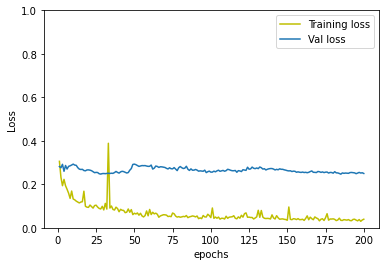

Epoch 1/200
3/3 [==============================] - 11s 4s/step - loss: 0.2056 - dice_coefficient: 0.7944 - val_loss: 0.3659 - val_dice_coefficient: 0.5780
Epoch 2/200
3/3 [==============================] - 10s 4s/step - loss: 0.2131 - dice_coefficient: 0.7869 - val_loss: 0.3544 - val_dice_coefficient: 0.6313
Epoch 3/200
3/3 [==============================] - 12s 5s/step - loss: 0.1745 - dice_coefficient: 0.8255 - val_loss: 0.3133 - val_dice_coefficient: 0.6980
Epoch 4/200
3/3 [==============================] - 12s 5s/step - loss: 0.1574 - dice_coefficient: 0.8426 - val_loss: 0.3104 - val_dice_coefficient: 0.7025
Epoch 5/200
3/3 [==============================] - 12s 5s/step - loss: 0.1265 - dice_coefficient: 0.8735 - val_loss: 0.2992 - val_dice_coefficient: 0.7128
Epoch 6/200
3/3 [==============================] - 10s 4s/step - loss: 0.2448 - dice_coefficient: 0.7552 - val_loss: 0.2949 - val_dice_coefficient: 0.7163
Epoch 7/200
3/3 [==============================] - 12s 5s/step - loss:

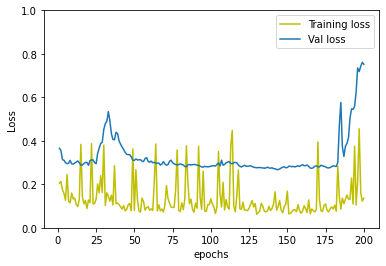

Epoch 1/200
3/3 [==============================] - 13s 5s/step - loss: 0.4562 - dice_coefficient: 0.5438 - val_loss: 0.5377 - val_dice_coefficient: 0.4988
Epoch 2/200
3/3 [==============================] - 12s 5s/step - loss: 0.3888 - dice_coefficient: 0.6112 - val_loss: 0.4666 - val_dice_coefficient: 0.5345
Epoch 3/200
3/3 [==============================] - 10s 4s/step - loss: 0.3763 - dice_coefficient: 0.6237 - val_loss: 0.4210 - val_dice_coefficient: 0.5738
Epoch 4/200
3/3 [==============================] - 10s 4s/step - loss: 0.3435 - dice_coefficient: 0.6565 - val_loss: 0.3926 - val_dice_coefficient: 0.6211
Epoch 5/200
3/3 [==============================] - 12s 5s/step - loss: 0.2734 - dice_coefficient: 0.7266 - val_loss: 0.3922 - val_dice_coefficient: 0.6275
Epoch 6/200
3/3 [==============================] - 12s 5s/step - loss: 0.2415 - dice_coefficient: 0.7585 - val_loss: 0.3880 - val_dice_coefficient: 0.6312
Epoch 7/200
3/3 [==============================] - 12s 5s/step - loss:

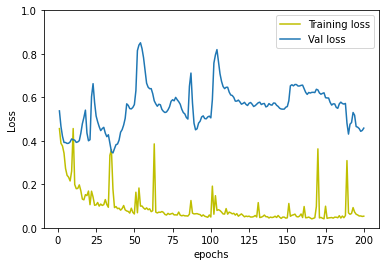

Epoch 1/200
2/2 [==============================] - 25s 20s/step - loss: 0.3845 - dice_coefficient: 0.6104 - val_loss: 0.4693 - val_dice_coefficient: 0.4702
Epoch 2/200
2/2 [==============================] - 10s 7s/step - loss: 0.3684 - dice_coefficient: 0.6337 - val_loss: 0.4938 - val_dice_coefficient: 0.4432
Epoch 3/200
2/2 [==============================] - 10s 7s/step - loss: 0.3379 - dice_coefficient: 0.6695 - val_loss: 0.4974 - val_dice_coefficient: 0.4399
Epoch 4/200
2/2 [==============================] - 10s 7s/step - loss: 0.2910 - dice_coefficient: 0.7096 - val_loss: 0.4845 - val_dice_coefficient: 0.4519
Epoch 5/200
2/2 [==============================] - 8s 5s/step - loss: 0.5400 - dice_coefficient: 0.4397 - val_loss: 0.4843 - val_dice_coefficient: 0.4514
Epoch 6/200
2/2 [==============================] - 10s 7s/step - loss: 0.2357 - dice_coefficient: 0.7690 - val_loss: 0.5049 - val_dice_coefficient: 0.4332
Epoch 7/200
2/2 [==============================] - 10s 7s/step - loss:

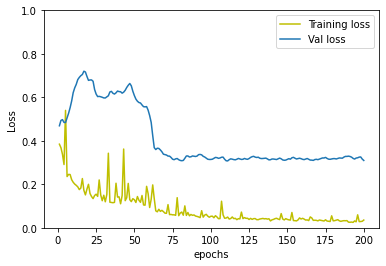

In [ ]:
model=unet_model_3d(dice_coefficient_loss,initial_learning_rate=0.0001, metrics=[dice_coefficient])
bs=24
for i in range(0,len(y_train),bs):
    X_batch=X_train[i:i+bs]
    y_batch=y_train[i:i+bs]
    history=model.fit(X_batch,y_batch,epochs=200,batch_size=8,validation_data=(X_val,y_val))#,callbacks=EarlyStopping(monitor='val_loss',patience=3,mode='min')

    loss = history.history['loss']
    val_loss=history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs,val_loss,label='Val loss')
    plt.ylim(0, 1)
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
pred=model.predict(X_test)
print(pred.shape)


(32, 32, 64, 64, 3)


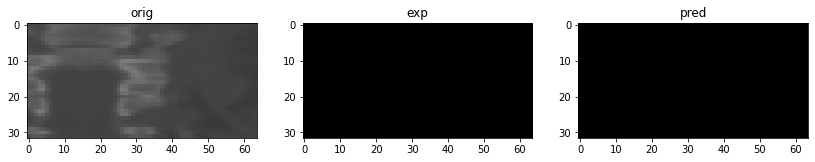

In [ ]:
plt.figure(figsize=(14,6))

plt.subplot(131)
plt.title('orig')
plt.imshow(X_test[5][:,50,:],cmap='gray')


plt.subplot(132)
plt.title('exp')
plt.imshow(y_test[5][:,50,:],cmap='gray')

plt.subplot(133)
plt.title('pred')
plt.imshow(pred[5][:,50,:],cmap='gray')

In [ ]:
res=model.evaluate(X_test,y_test,batch_size=8)
res

4/4 [==============================] - 4s 724ms/step - loss: 0.3512 - dice_coefficient: 0.6488


[0.3512382507324219, 0.6487617492675781]

In [ ]:
model.save('/kaggle/working/unet_model_20.h5')